## Basic Steps:
1. If using custom word make new file in data_prep folder using this structure /data_prep/custom_word/custom_word
2. Move over existing word dataset to data_prep folder using this strucutre /data_prep/existing_word/existing_word\
    *Again MOVE the folder do not copy it
3. "Get Custom data" is used to input custom words. Change file direcory name accordingly
4. Once custom data is aquired use "Data Augmentation" to expand the custom dataset by creating slightly augmented copies of the original 
5. Next we copy some of these newly created files to the validation test set text document using "Write augmented data files to testing and validation .txt file" 
6. Now run "Copy augmented data to training data set" to copy folder in data_prep directory to the speech_train directory

In [1]:
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op

import numpy as np
import time
# from pydub import AudioSegment
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob
from datetime import datetime as dt
from numpy import log as ln
# from td_utils import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# To generate wav file from np array.
from scipy.io.wavfile import write

import IPython
import IPython.display as ipd
import tensorflow as tf
%matplotlib inline
import pyaudio
from queue import Queue
from threading import Thread
import math
import time
import librosa

In [2]:
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
label_list        = ['_silence', '_unknown', 'armadillo', 'backward']
spectrogram_shape = (64, 24, 32, 1)

In [3]:
chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
sample_rate = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

# Get Custom Data

#### Run this code to get in an audio sample

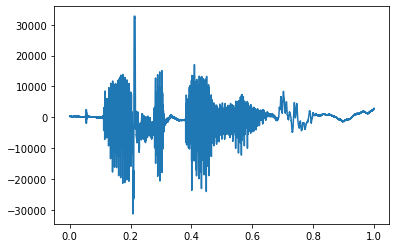

In [5]:
# Queue to communiate between the audio callback and main thread
q = Queue()
run = True
silence_threshold = 100
# Run the demo for a timeout seconds
timeout = time.time() + 1 
# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()
try:
    while run:        
        data = q.get()
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False      
stream.stop_stream()
stream.close()

sample_rate = fs


#Displaying wave file data
plt.plot(np.arange(1*fs)/fs, data)
plt.show()
ipd.Audio(data, rate=fs)

#### If the Sample looks good run cell below to save it 

In [6]:
# #saving the wave file to training_data
date_str = dt.now().strftime("%H%M%S").lower()
current_name = f"data/data_prep/armadillo/Test{date_str}.wav"
write(current_name, sample_rate, data)


# Data Augmentation
* First create 5 instances of each audio sample, original and then time shifted forward .5s in 1/8s increments
* Then pitch shift each time shifted audio sample until desired amount of training data is met

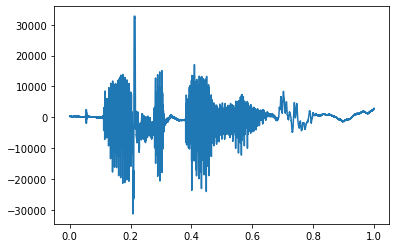

In [7]:
#Data_prep directory is solely for holding data folders for augmentation import
#select keyword that you want to add files from
keyword='armadillo'
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/data_prep/'+str(keyword)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly


test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

In [8]:
test_wav

array([ 263,  401,  391, ..., 2899, 2934, 2788], dtype=int16)

In [9]:
#Data_prep directory is solely for holding data folders for augmentation import
#select keyword that you want to add files from
keyword='armadillo'
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/data_prep/'+str(keyword)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]

'\\Users\\Jeromey\\IOT\\Project1\\data\\data_prep\\armadillo\\Test211932.wav'

In [10]:
#Testing if noise files import correctly
noise_samples= tf.io.gfile.glob('/Users/Jeromey/IOT/Project1/data/data_prep/augmentation_samples' + '/*.wav')
noise_samples[0]

'\\Users\\Jeromey\\IOT\\Project1\\data\\data_prep\\augmentation_samples\\noise_1.wav'

In [11]:
noise_count=4
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*len(noise_samples)*noise_count, "noise augmented files, to give a total of",len(filenames)*len(noise_samples)*(noise_count)+len(filenames),"files")

This will expand the current 1 files by creating an addtional 12 noise augmented files, to give a total of 13 files


In [12]:
noise_dict={}
for index in range(len(filenames)):
    test_wav=filenames[index]
    fs, test_wav = wavfile.read(test_wav)
    if (len(test_wav) < fs):
        padding=fs-len(test_wav)
        extra_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
        test_wav=np.concatenate((test_wav,extra_padding),axis=0).astype(np.int16)
    noise_dict[0]=test_wav.astype(np.int16)
    for i in range(len(noise_samples)):
        noise=noise_samples[i]
        fs, noise = wavfile.read(noise)
        for j in range(noise_count):
            noise_multiplier=round(max(test_wav)*(j/2000))
            noise_lvl=noise*noise_multiplier
            test_wave_with_noise=np.add(test_wav,noise_lvl)
            current_name = "data/data_prep/" +str(keyword)+'/' + str(keyword)+f"_Sample{index}_Noise{i}_Multiplier{j}.wav"
            write(current_name, fs, test_wave_with_noise)
            noise_dict[j+1]=test_wave_with_noise.astype(np.int16)
            noise_dict[j+5]=noise_lvl.astype(np.int16)

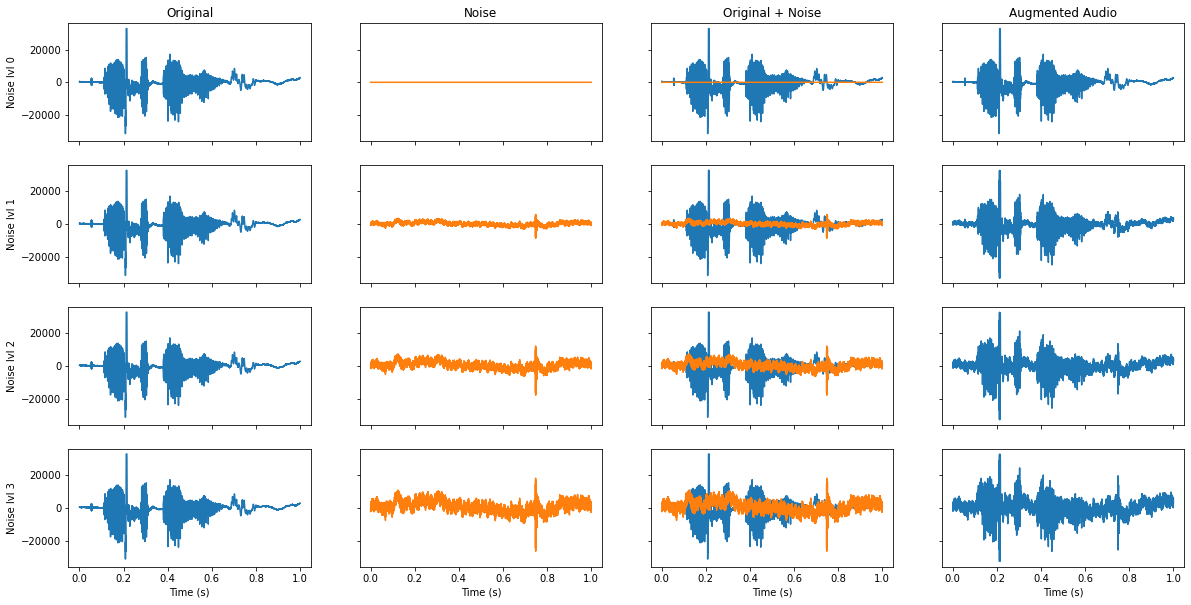

In [13]:
fig, axs = plt.subplots(4, 4,figsize=(20,10), sharex=True,sharey=True)
axs[0,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,1].plot(np.arange(1*fs)/fs, noise_dict[5], 'tab:orange')
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[0,2].plot(np.arange(1*fs)/fs, noise_dict[5])
axs[0,3].plot(np.arange(1*fs)/fs, noise_dict[1])

axs[0, 0].set_title("Original")
axs[0, 1].set_title("Noise")
axs[0, 2].set_title("Original + Noise")
axs[0, 3].set_title("Augmented Audio")

axs[0, 0].set(xlabel='Time (s)', ylabel='Noise lvl 0')
axs[1, 0].set(xlabel='Time (s)', ylabel='Noise lvl 1')
axs[2, 0].set(xlabel='Time (s)', ylabel='Noise lvl 2')
axs[3, 0].set(xlabel='Time (s)', ylabel='Noise lvl 3')

axs[1,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,1].plot(np.arange(1*fs)/fs, noise_dict[6], 'tab:orange')
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[1,2].plot(np.arange(1*fs)/fs, noise_dict[6])
axs[1,3].plot(np.arange(1*fs)/fs, noise_dict[2])

axs[2,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,1].plot(np.arange(1*fs)/fs, noise_dict[7], 'tab:orange')
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[2,2].plot(np.arange(1*fs)/fs, noise_dict[7])
axs[2,3].plot(np.arange(1*fs)/fs, noise_dict[3])

axs[3,0].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,1].plot(np.arange(1*fs)/fs, noise_dict[8], 'tab:orange')
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[0])
axs[3,2].plot(np.arange(1*fs)/fs, noise_dict[8])
axs[3,3].plot(np.arange(1*fs)/fs, noise_dict[4])

for ax in axs.flat:
    ax.set(xlabel='Time (s)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [14]:
from IPython.display import Audio 
from IPython.display import display

print("Noise lvl 0:")
display(Audio(noise_dict[0], rate=fs))
print("Noise lvl 1:")
display(Audio(noise_dict[2], rate=fs))
print("Noise lvl 2:")
display(Audio(noise_dict[3], rate=fs))
print("Noise lvl 3:")
display(Audio(noise_dict[4], rate=fs))


Noise lvl 0:


Noise lvl 1:


Noise lvl 2:


Noise lvl 3:


### Time Shift
##### This will create 1/8s time shifted copies of data in designated prep_folder

In [15]:
#Data_prep directory is solely for holding data folders for augmentation import
#select keyword that you want to add files from
keyword='armadillo'
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/data_prep/'+str(keyword)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
#Testing if audio data imported correctly
filenames[0]

'\\Users\\Jeromey\\IOT\\Project1\\data\\data_prep\\armadillo\\armadillo_Sample0_Noise0_Multiplier0.wav'

In [16]:
#initializing variables for 1/8th second time shifts
one_eighth=int((sample_rate/8)) #16k sample rate means 2k for 1/8s
padding=one_eighth #Number of samples to pad
#zero_padding=np.zeros(padding).astype(np.int16) #array of empty audio to pad with
noise_lvl_min=-200 #about the min for quiet room when measured with get data code above
noise_lvl_max=200 #about the max for quiet room when measured with get data code above
noise_padding=np.random.randint(noise_lvl_min,noise_lvl_max+1,padding) #makes random noise

In [17]:
#how many of each type of time shift is desired..in 1/8s increments
left_1=2
left_2=2
left_3=1
right_1=2
right_2=2
right_3=1
zero_shift=2
total=zero_shift+right_3+right_2+right_1+left_3+left_2+left_1

In [18]:
print("This will expand the current", len(filenames), "files by creating an addtional",len(filenames)*total, "time shifted files, to give a total of",len(filenames)*(total+1),"files")

This will expand the current 13 files by creating an addtional 156 time shifted files, to give a total of 169 files


In [19]:
#creates dictionary to hold audio for data visualization
audio_dict={}

random_list = list(range(0, len(filenames))) #create array [1,2,3...]
random.shuffle(random_list) #randomize the array

#runs 5x shifts audio from original to left by .5sec in 1/8s increments
for index in range(len(filenames)):
    test_wav=filenames[random_list[index]]
    fs, test_wav = wavfile.read(test_wav)
    audio_dict[0]=test_wav.astype(np.int16)#dict[0] holds original audio
    test_wav_decrease = test_wav #creating copy to be manipulated 
    test_wav_increase = test_wav #creating copy to be manipulated
    
    #shift audio to left in 1/8s increments
    for j in range(1,4):#dict 1-4 hold shifted audio (change 4 to 5 to make 1/2s shift)
        for i in range (one_eighth):
            test_wav_decrease=np.delete(test_wav_decrease,0)
        test_wav_decrease=np.concatenate((test_wav_decrease,noise_padding),axis=0).astype(np.int16)
        audio_dict[j]=test_wav_decrease.astype(np.int16)
        if (j==1):
            for p in range(left_1): #creates left_1 copys shifted left 1/8s
                current_name = "data/data_prep/" +str(keyword)+'/'+str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==2):
            for p in range(left_2): #creates left_2 copys shifted left 2/8s
                current_name = "data/data_prep/" +str(keyword)+'/'+str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (j==3):
            for p in range(left_3): #creates left_3 copy shifted left 3/8s
                current_name = "data/data_prep/" +str(keyword)+'/'+str(keyword)+f"_Sample{index}_LShift{j}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
    
    #shift audio to right in 1/8s increments
    for k in range(6,9):
        #pad zeros to front
        test_wav_increase=np.concatenate((noise_padding,test_wav_increase),axis=0)
        #delete data past 16k samples
        for d in range(sample_rate,len(test_wav_increase)):
            test_wav_increase=np.delete(test_wav_increase,sample_rate,0).astype(np.int16)
        audio_dict[k]=test_wav_increase
        if (k==6):
            for p in range(right_1): #creates right_1 copys shifted right 1/8s
                current_name = "data/data_prep/" +str(keyword)+'/' +str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==7):
            for p in range(right_2): #creates right_2 copys shifted right 2/8s
                current_name = "data/data_prep/" +str(keyword)+'/' +str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
        if (k==8):
            for p in range(right_3): #creates right_3 copy shifted right 3/8s
                current_name = "data/data_prep/" +str(keyword)+'/' +str(keyword)+f"_Sample{index}_RShift{k-5}_{p}.wav"
                write(current_name, fs, test_wav_decrease)
    for l in range(zero_shift):
        current_name = "data/data_prep/" +str(keyword)+'/' +str(keyword)+f"_Sample{index}_NoShift_{l}.wav"
        write(current_name, fs, test_wav)

#### Plot time shifted audio

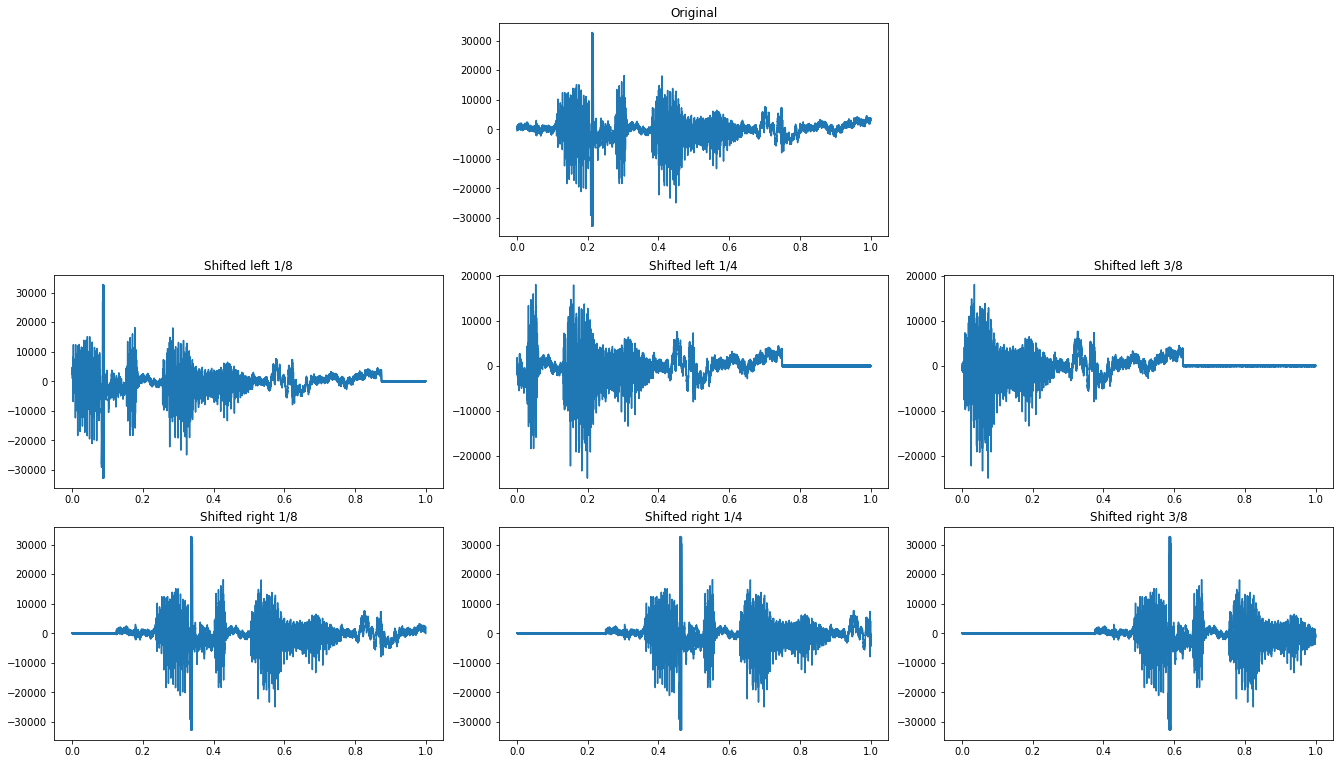

In [20]:
#commented out is for half second shift if desired

fig = plt.figure(constrained_layout=True)
axs = fig.add_gridspec(3, 3)

f_ax0 = fig.add_subplot(axs[0, 1])
f_ax1 = fig.add_subplot(axs[1, 0])
f_ax2 = fig.add_subplot(axs[1, 1])
f_ax3 = fig.add_subplot(axs[1, 2])
# f_ax4 = fig.add_subplot(axs[2, 3])
f_ax6 = fig.add_subplot(axs[2, 0])
f_ax7 = fig.add_subplot(axs[2, 1])
f_ax8 = fig.add_subplot(axs[2, 2])
# f_ax9 = fig.add_subplot(axs[3, 3])

f_ax0.plot(np.arange(1*fs)/fs, audio_dict[0])
f_ax1.plot(np.arange(1*fs)/fs, audio_dict[1])
f_ax2.plot(np.arange(1*fs)/fs, audio_dict[2])
f_ax3.plot(np.arange(1*fs)/fs, audio_dict[3])
# f_ax4.plot(np.arange(1*fs)/fs, audio_dict[4])
f_ax6.plot(np.arange(1*fs)/fs, audio_dict[6])
f_ax7.plot(np.arange(1*fs)/fs, audio_dict[7])
f_ax8.plot(np.arange(1*fs)/fs, audio_dict[8])
# f_ax9.plot(np.arange(1*fs)/fs, audio_dict[9])

f_ax0.set_title('Original')
f_ax1.set_title('Shifted left 1/8')
f_ax2.set_title('Shifted left 1/4')
f_ax3.set_title('Shifted left 3/8')
# f_ax4.set_title('Shifted left 1/2')
f_ax6.set_title('Shifted right 1/8')
f_ax7.set_title('Shifted right 1/4')
f_ax8.set_title('Shifted right 3/8')
# f_ax9.set_title('Shifted right 1/2')
fig.set_size_inches(18.5, 10.5, forward=True)
pass

#### Listen to time shifted Audio

In [21]:
from IPython.display import Audio 
from IPython.display import display

print("Original:")
display(Audio(audio_dict[0], rate=fs))
print("Shifted left 1/8:")
display(Audio(audio_dict[1], rate=fs))
print("Shifted left 1/4:")
display(Audio(audio_dict[2], rate=fs))
print("Shifted left 3/8:")
display(Audio(audio_dict[3], rate=fs))
# print("Shifted left 1/2:")
# display(Audio(audio_dict[4], rate=fs))
print("Shifted right 1/8:")
display(Audio(audio_dict[6], rate=fs))
print("Shifted right 1/4:")
display(Audio(audio_dict[7], rate=fs))
print("Shifted right 3/8:")
display(Audio(audio_dict[8], rate=fs))
# print("Shifted right 1/2:")
# display(Audio(audio_dict[9], rate=fs))

Original:


Shifted left 1/8:


Shifted left 1/4:


Shifted left 3/8:


Shifted right 1/8:


Shifted right 1/4:


Shifted right 3/8:


### Pitch Shift

In [22]:
#Data_prep directory is solely for holding data folders for augmentation import
#select keyword that you want to add files from
keyword='armadillo'
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/data_prep/'+str(keyword)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

In [23]:
#Testing if it read files correctly
filenames[0]

'\\Users\\Jeromey\\IOT\\Project1\\data\\data_prep\\armadillo\\armadillo_Sample0_LShift1_0.wav'

In [24]:
print("The current number of files in directory is", len(filenames))

The current number of files in directory is 169


In [25]:
#How many of the files do you want to have total?
desired_number_of_files=400

### Doubling Equation:   
> $output=input * 2^{x}$

*Here $x$ is the number of times input is doubled

#### To get desired number of output files from input when loop doubles input every iteration of the for loop we solve for $x$:
   
> $x=\log _{2}(\frac{out}{in})$\
  $x=\frac{\ln (\frac{out}{in})} {\ln (2)}$
                 
#### Next $math.ceil()$ is used to round up to integer for loop iteration

> $x=$ math.ceil$(\frac{\ln (out)}{\ln (in)})$

In [26]:
#Doubling formula used to find range for outer for loop indexing with "i"
outer_range= math.ceil((np.log(desired_number_of_files / len(filenames)) / np.log(2) ))
outer_range

2

In [27]:
#uncomment below if you want to create a custom # < len(filenames)
#for index in range(40000): 
#for loop will double the files in len(filenames) with slight speed alterations
for i in range(outer_range):
    for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
        test_wav_float=test_wav.astype(float)
        test_wav_pitch_shifted = librosa.effects.pitch_shift(test_wav_float, sr=sample_rate, n_steps=-0.25*(i+1))
        test_wav_pitch_shifted_int=test_wav_pitch_shifted.astype(np.int16)
        current_name = f"data/data_prep/armadillo/armadillo_Pitch_Shift_{i}_{index}.wav"    
        write(current_name, fsamp, test_wav_pitch_shifted_int)
        files_in_folder=len(tf.io.gfile.glob(str(data_dir) + '/*.wav'))
        if (files_in_folder >= desired_number_of_files):
            break 
    filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
    #update filenames with newly created files    
    if (files_in_folder >= desired_number_of_files):
        break 
print("Congratulations, the current number of files in directory is", len(filenames))

Congratulations, the current number of files in directory is 400


# Write augmented data files to testing and validation .txt file 

In [ ]:
#select keyword that you want to add files from
keyword='backward'
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/data_prep/'+str(keyword)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

In [ ]:
#Verifying opens files correctly
filenames[0]

In [ ]:
num_files=len(filenames)
num_files

In [ ]:
random_list = list(range(0, num_files)) #create array [1,2,3...]
random.shuffle(random_list) #randomize the array

In [ ]:
from pathlib import Path

#Set directory for validation list
dir_path = Path('/Users/Jeromey/IOT/Project1/data/speech_train/')
#dir_path = Path('/Users/Jeromey/IOT/Project1/data/data_prep/')
file_name = 'validation_list.txt'

#How many files to add to document?
add_val_num=5000

# check if directory exists
#copys over files to the validation document
if dir_path.is_dir():
    f = open (dir_path.joinpath(file_name),'a')
    filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')
    for i in range(add_val_num):
        f.write('\nbackward\\'+os.path.basename(filenames[random_list[i]]))
    f.close()
    print(add_val_num, keyword, "samples added to", file_name)
else:
    print('Directory doesnt exist')

# Copy augmented data to training data set

## Warning:
> ##### This will copy both folders designeted in label_list 2 and 3

In [ ]:
print('The next block will copy of',label_list[2], 'and',label_list[3], 'folders from data_prep directory and transfer it to speech_train directory')

In [ ]:
import shutil
import os

for i in range(2,4):
    
    # path to source directory
    src_dir = '/Users/Jeromey/IOT/Project1/data/data_prep/'+label_list[i]

    # path to destination directory
    dest_dir = '/Users/Jeromey/IOT/Project1/data/speech_train/'+label_list[i]

    # getting all the files in the source directory
    files = os.listdir(src_dir)

    shutil.copytree(src_dir, dest_dir)


# Normalizing the data

#### For all training Data

In [ ]:
# data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/speech_train/'))
# filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')

#### For armadillo data prep folder

In [28]:
data_dir = pathlib.Path(os.path.join('/Users/Jeromey/IOT/Project1/data/data_prep/armadillo'))
filenames = tf.io.gfile.glob(str(data_dir) + '/*.wav')

In [29]:
filenames[0]

'\\Users\\Jeromey\\IOT\\Project1\\data\\data_prep\\armadillo\\armadillo_Pitch_Shift_0_0.wav'

In [30]:
len(filenames)

400

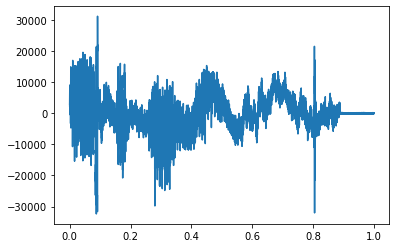

In [31]:
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)

#### Multiply up to noise lvl

In [32]:
multiplier=10
for i in range(1,multiplier):
    for index in range(len(filenames)):
            test_wav=filenames[index]
            fs, test_wav = wavfile.read(test_wav)
            sound=test_wav*(i)
            sound_normalized=sound.astype(np.int16)
            current_name = f"data/data_prep/armadillo/armadillo_jer_noiseLVL_{i}_{index}.wav" 
            write(current_name, fsamp, sound_normalized)
            if ((index%10)==0):
                print(f"{index}/{len(filenames)} complete")

0/400 complete
10/400 complete
20/400 complete
30/400 complete
40/400 complete
50/400 complete
60/400 complete
70/400 complete
80/400 complete
90/400 complete
100/400 complete
110/400 complete
120/400 complete
130/400 complete
140/400 complete
150/400 complete
160/400 complete
170/400 complete
180/400 complete
190/400 complete
200/400 complete
210/400 complete
220/400 complete
230/400 complete
240/400 complete
250/400 complete
260/400 complete
270/400 complete
280/400 complete
290/400 complete
300/400 complete
310/400 complete
320/400 complete
330/400 complete
340/400 complete
350/400 complete
360/400 complete
370/400 complete
380/400 complete
390/400 complete
0/400 complete
10/400 complete
20/400 complete
30/400 complete
40/400 complete
50/400 complete
60/400 complete
70/400 complete
80/400 complete
90/400 complete
100/400 complete
110/400 complete
120/400 complete
130/400 complete
140/400 complete
150/400 complete
160/400 complete
170/400 complete
180/400 complete
190/400 complete
20

#### Normalize to specific noise level

In [ ]:
noise_level=12000
for index in range(len(filenames)):
        test_wav=filenames[index]
        fs, test_wav = wavfile.read(test_wav)
        sound=test_wav*15
        #sound = test_wav*(noise_level/max(test_wav))
        sound_normalized=sound.astype(np.int16)
        current_name = f"data/data_prep/armadillo/armadillo_jer_8_{index}.wav" 
        #current_name = filenames[index]
        write(current_name, fsamp, sound_normalized)
        if ((index%10)==0):
            print(f"{index}/{len(filenames)} complete")

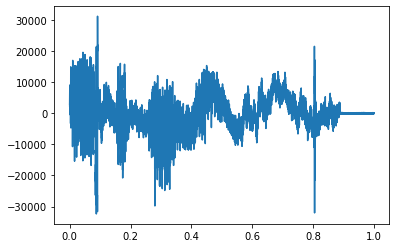

In [33]:
test_wav=filenames[0]
fs, test_wav = wavfile.read(test_wav)
plt.plot(np.arange(1*fs)/fs, test_wav)
plt.show()
ipd.Audio(test_wav, rate=fs)